# Assignment Data Science
## Assignment 1: Predict whether an sms message is spam or not

[Dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

1.	Preliminary descriptive statistics, for example:
    1.	Determine the frequency of each word in the collection (logplot?)
    2.	Determine the strongest correlations among words
    3.	Word frequencies per class etc.

2.	Feature engineering
    1.	Stop words, stemming, feature selection, etc.
    2.	Transformation to bag of words, n-grams, etc.
    3.	Normalization of frequencies (with reference corpus, or wrt the corpus itself)

3.	Model fitting
    1.	Fit a decision tree model to predict the target variable 

4.	Evaluate
    1.	Do a proper, critical evaluation within the business context (at least display the confusion matrix)


## 1.0 Preliminary steps
### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as pl
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS, TfidfTransformer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

import re
import os

from wordcloud import WordCloud

%matplotlib inline

In [2]:
%matplotlib inline
pd.options.plotting.backend = 'plotly'


### Load dataset

In [3]:
missing_values_string = [' ', '', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND',
                         '1.#QNAN', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null']

In [4]:
df = pd.DataFrame(pd.read_csv('./data/SMSSpamCollection',sep="\t",names=['Label','Message'], na_values=missing_values_string))


## 1.1 Descriptive analysis

In [5]:
print('Shape:' , df.shape)
df.head()

Shape: (5572, 2)


Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

The dataset contains 5572 messages with an indication if it is ham or spam.

Check the data quality to look for missing values (some double check on the correctness of the reference document)
Also make the data type of Label category instead of object

In [6]:
assert df.isna().sum().sum() == 0

In [7]:
df.Label = df.Label.astype('category')
df.dtypes


Label      category
Message      object
dtype: object

Let's add the length of the message as a feature and do some analysis on ham and spam


In [8]:
df['Length'] = df.Message.apply(lambda x: len(x.split()))  

In [9]:
ham_df = df[df.Label == 'ham']
spam_df = df[df.Label == 'spam']
ham_df.head()

Label                                            Message  Length
0   ham  Go until jurong point, crazy.. Available only ...      20
1   ham                      Ok lar... Joking wif u oni...       6
3   ham  U dun say so early hor... U c already then say...      11
4   ham  Nah I don't think he goes to usf, he lives aro...      13
6   ham  Even my brother is not like to speak with me. ...      16

In [10]:
spam_df.Message.values[0:5]

array(["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
       'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
       'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030',
       'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info'],
      dtype=object)

Let's see if the length of the message tells us something

In [11]:
length_df = pd.DataFrame({'All':df.Length,'Ham':ham_df.Length,'Spam':spam_df.Length})
length_df.describe()

All          Ham        Spam
count  5572.000000  4825.000000  747.000000
mean     15.597452    14.310259   23.911647
std      11.404053    11.517945    5.780174
min       1.000000     1.000000    2.000000
25%       7.000000     7.000000   22.000000
50%      12.000000    11.000000   25.000000
75%      23.000000    19.000000   28.000000
max     171.000000   171.000000   35.000000

In [12]:
px.violin(df, x="Label", y="Length", color="Label")

We can clearly see that the spread of the length of a spam message is smaller and the mean of a spam message is higher than that of a ham message.
The ham message tend to be a bit shorter in general but distribution is more spread with outliers. So it appears that their is some relation between the length of a message and it's label.

In [13]:
px.scatter(df, y="Length", color="Label")

### Do we have a balanced dataset?

       Message  Length
Label                 
ham       4825    4825
spam       747     747


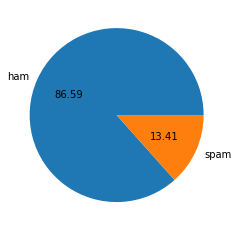

In [14]:
cntLabels = df.groupby(by="Label").count()
plt.pie(cntLabels.Message,labels=cntLabels.index,autopct="%.2f")
print(cntLabels)

As we can see the dataset is unbalanced. This tells us already that accuracy will not be a good metric for evaluation.

### Visualisations
Let's do some visualisations to see the most frequently used words
* A wordcloud gives a visual impression of important words
* A bar plot for the most frequently used words
* A bar plot for the least frequently used words
* A bar plot for the most frequently used words in ham
* A bar plot for the most frequently used words in spam

For that we create a reusable function:

In [15]:
def vectorize_to_df(textSeries:pd.Series, vectorizer):
    X = vectorizer.fit_transform(textSeries)
    wordcount_df = pd.DataFrame(data=X.sum(axis=0).transpose() ,index=vectorizer.get_feature_names(), columns=['frequency'])
    return wordcount_df.sort_values(by="frequency",ascending=False)

def add_graph(serie:pd.Series):
    return go.Bar(x=serie.frequency, y=serie.index, orientation='h',name="")

def visualize_word_usage(textSeries:pd.Series,hamSeries:pd.Series, spamSeries:pd.Series, vectorizer, title:str, includeWordCloud=False, take=20 ):
    
    wordcount_df = vectorize_to_df(textSeries,vectorizer)
    #print(wordcount_df.head(10))
    if includeWordCloud: print('Number of words: ', len(vectorizer.get_feature_names()))
        
    if includeWordCloud:
        word_cloud = WordCloud(background_color="white", width=800, height=600, max_words=200).generate_from_frequencies(wordcount_df.frequency)
        plt.figure(figsize=[10,15])
        plt.axis('off')
        plt.imshow(word_cloud)
    
    fig = pl.subplots.make_subplots(rows=2, cols=2,subplot_titles=[f"Top {take} words",f"Bottom {take} words",
                                                                  f"Ham Top {take} words", f"Spam Top {take} words",])
    #top
    fig.add_trace(add_graph(wordcount_df.head(take)),row=1, col=1)
    #bottom
    fig.add_trace(add_graph(wordcount_df.tail(take)),row=1, col=2)
    #top ham
    ham = vectorize_to_df(hamSeries,vectorizer)
    fig.add_trace(add_graph(ham.head(take)),row=2, col=1)
    #top spam
    spam = vectorize_to_df(spamSeries,vectorizer)
    fig.add_trace(add_graph(spam.head(take)),row=2, col=2)
    
    fig.update_layout(height=take*25*2, width=960, title_text=title,yaxis=dict(autorange="reversed"),showlegend=False)
    fig.update_yaxes(autorange="reversed")
    fig.show()
    

Let's start by using a very simple CountVectorizer to get a list of all the words and their counts. We remove the stop words to lower the amount of less meaningfull words/features (From 8713 => 8444).

Number of words:  8444


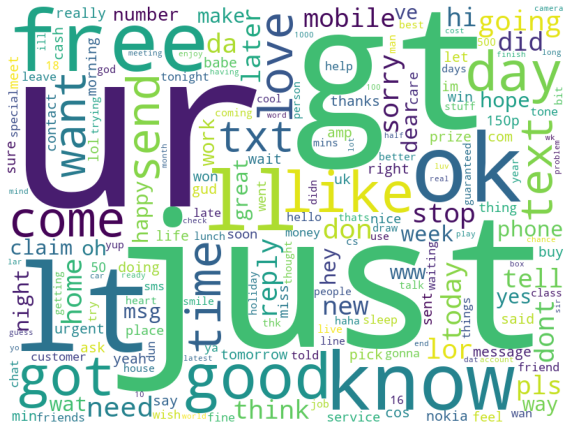

In [16]:
cntVectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
visualize_word_usage(df.Message, ham_df.Message, spam_df.Message, cntVectorizer,"CountVectorizer Frequency of Words", True)

Some strange 'words' likt gt, lt and ur appear in our top lists.


In [17]:
df[df.Message.str.contains('gt;')].Message.values[0:5]

array(['Great! I hope you like your man well endowed. I am  &lt;#&gt;  inches...',
       'A gram usually runs like  &lt;#&gt; , a half eighth is smarter though and gets you almost a whole second gram for  &lt;#&gt;',
       'Do you know what Mallika Sherawat did yesterday? Find out now @  &lt;URL&gt;',
       'Does not operate after  &lt;#&gt;  or what',
       "Turns out my friends are staying for the whole show and won't be back til ~ &lt;#&gt; , so feel free to go ahead and smoke that $ &lt;#&gt;  worth"],
      dtype=object)

lt and gt seems to be some html entity chars for < and > often combined and looking like a replacement for quantitive elements like size, time. This could be some already preprocessed data or wrongly encoded data.

In [18]:
df[df.Message.str.contains(' ur ')].Message.values[0:10]

array(['England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/ú1.20 POBOXox36504W45WQ 16+',
       'Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?',
       'Today is "song dedicated day.." Which song will u dedicate for me? Send this to all ur valuable frnds but first rply me...',
       'Ela kano.,il download, come wen ur free..',
       'Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx',
       "Wa, ur openin sentence very formal... Anyway, i'm fine too, juz tt i'm eatin too much n puttin on weight...Haha... So anythin special happened?",
       "Want 2 get laid tonight? Want real Dogging locations sent direct 2 ur mob? Join the UK's largest Dogging Network bt Txting GRAVEL to 69888! Nt. ec2a. 31p.msg@150p",
       'I place all ur points on e cultures module already.',
       'Ok no prob. Take ur time.',
       'Will u meet ur dream part

ur seems to be the short form of your. There's a lot of sms specific language ('2 iso 'to','u' iso 'you', etc.), abbreviations that we might take into account when preprocessing the data!


Let's do the same for a TfidfVectorizer. A Tfidf vectorizer will take the inverse document frequency into account meaning that if a word occurs in a lot of document, the importance of the word will decrease.

In [19]:
tf_idf_vectorizer =  TfidfVectorizer(norm='l1',stop_words=ENGLISH_STOP_WORDS) 
visualize_word_usage(df.Message,ham_df.Message,spam_df.Message, tf_idf_vectorizer, 'Tf-Idf of words', True)


Number of words:  8444


## 1.2 Preprocessing, model exploration and (visualisation of) evaluation


Some general preprocessing steps are often covered in vectorizers (lower case, removal of punctuation, stop words), so we will let the vectorizers handle these. It would be interesting to have a stop words list tailored to sms messages. Further on, I'll test with and without stop words.

Stemming and lemmatization might also reduce the feature dimensionality but i'm uncertain if it would be very beneficial in sms messages. the nltk library has both stemming and lemmatization functionalities.

From experience we know that spam messages typically ask the receiver to perform an action (text, call or go to website). Given the numerous possible urls and phone number, standard text processing will see them as individual tokens. Therefore it might be interesting to categorize them as phone numbers, urls or mentions of money within the message. We could preprocess the message and replace these individual tokens by a category but having them as extra features, will keep the original messages.

Additional ideas for preprocessing is to give special attention to domain names. We could create separate domain name features and match them against a list of malicious/safe domain names (not implemented but it could be a boolean feature like\
`df['ContainsSuspiciousDomainName'] = df.Message.apply(lambda x:  suspiciousDomains.contains(domainName(x))) `).

Other data like the phonenumber and a contact list from the receiver of the message would also be good candidates to improve performance of the model.


Dear Voucher Holder, 2 claim this weeks offer, at your PC go to http://www.e-tlp.co.uk/expressoffer Ts&Cs apply.2 stop texts txt STOP to 80062.
Dear Voucher Holder, To claim this weeks offer, at you PC please go to http://www.e-tlp.co.uk/expressoffer Ts&Cs apply. To stop texts, txt STOP to 80062


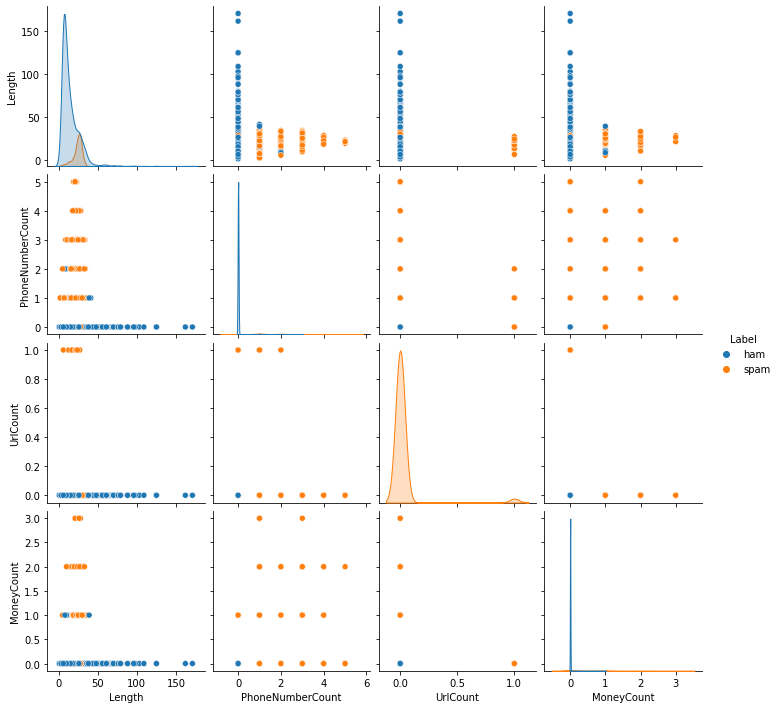

In [20]:
#these are just very rough regexp and should definitely be improved
df['PhoneNumberCount'] = df.Message.apply(lambda x: len(re.findall('[+]*[(]{0,1}[0-9]{1,4}[)]{0,1}[-\s\./0-9]{4,14}',x)))
df['UrlCount'] = df.Message.apply(lambda x: len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',x)))
df['MoneyCount'] = df.Message.apply(lambda x: len(re.findall('[£|€]\s?(([1-9]{1,3}(,{0,1} {0,1}\d{3})*(\.\d{2})?)|(0\.[1-9]\d)|(0\.0[1-9]))',x)))
print(df.Message.values[635])
print(df.Message.values[833])
df[df.UrlCount > 0].head(20)
df_scatter = df.drop(labels="Message", axis=1)
sns.pairplot(df_scatter,hue="Label")

We split the dataset into a test and training set to avoid data leakage to the model we're training.
We take 30% as test data, shuffle the dataset and stratify our labels to have an equal class distribution in our test and training set. The random state ensure that subsequent calls to the method will return the same dataset.

In [21]:
X = df.drop(labels='Label',axis=1)
print(X.head())
label = df.Label
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.3, random_state=21, shuffle=True, stratify=label)

                                             Message  Length  \
0  Go until jurong point, crazy.. Available only ...      20   
1                      Ok lar... Joking wif u oni...       6   
2  Free entry in 2 a wkly comp to win FA Cup fina...      28   
3  U dun say so early hor... U c already then say...      11   
4  Nah I don't think he goes to usf, he lives aro...      13   

   PhoneNumberCount  UrlCount  MoneyCount  
0                 0         0           0  
1                 0         0           0  
2                 3         0           0  
3                 0         0           0  
4                 0         0           0  


We create a few functions to do the repetitive work:

In [22]:
def vectorize_predict(vectorizer, classifier):
    '''
    Vectorizes the train and test set, trains the model with the classifier and returns the prediction.

            Parameters:
                    vectorizer (vectorizer): the vectorizer
                    classifier (classifier): the classifier

            Returns:
                    prediction (str): the prediction for the vectorized test set
    '''
    text_train_vect = vectorizer.fit_transform(X_train.Message)
    text_test_vect = vectorizer.transform(X_test.Message)
    classifier.fit(text_train_vect, y_train)
    y_test_pred = classifier.predict(text_test_vect)
    return y_test_pred

def evaluate_any(y_truth, y_test_pred):
    '''
    prints the classification report and return report and confusion matrix.

            Parameters:
                    y_test_pred (panda.Series): the vectorizer
                    
            Returns:
                    report: the classification report
                    cf_matrix: the confusion matrix
    '''
    report = classification_report(y_truth, y_test_pred)
    
    print('Classification report:\n', report)
    
    cf_matrix = confusion_matrix(y_truth, y_test_pred)
    #plot the confusion matrix
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham','spam'], yticklabels=['ham','spam'])
    plt.xlabel('Predictions')
    plt.ylabel('Ground truth')
    plt.show()
    
    print('MCC: ', f'{matthews_corrcoef(y_truth, y_test_pred):.4f}')
    
def evaluate(y_test_pred):
    return evaluate_any(y_test,y_test_pred)

#### CountVectorizer + DecisionTree

In [23]:
decisionTree = DecisionTreeClassifier(max_depth=5)
vec = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
evaluate(vectorize_predict(vec, decisionTree))


Classification report:
               precision    recall  f1-score   support

         ham       0.92      0.99      0.96      1448
        spam       0.91      0.45      0.60       224

    accuracy                           0.92      1672
   macro avg       0.91      0.72      0.78      1672
weighted avg       0.92      0.92      0.91      1672



MCC:  0.6039


In [24]:
import graphviz
from sklearn import tree
def visualize_tree(decision_tree, feature_names):
    dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                                    feature_names=feature_names,  
                                    class_names=decisionTree.classes_,
                                    filled=True)

    # Draw graph
    return graphviz.Source(dot_data, format="png") 



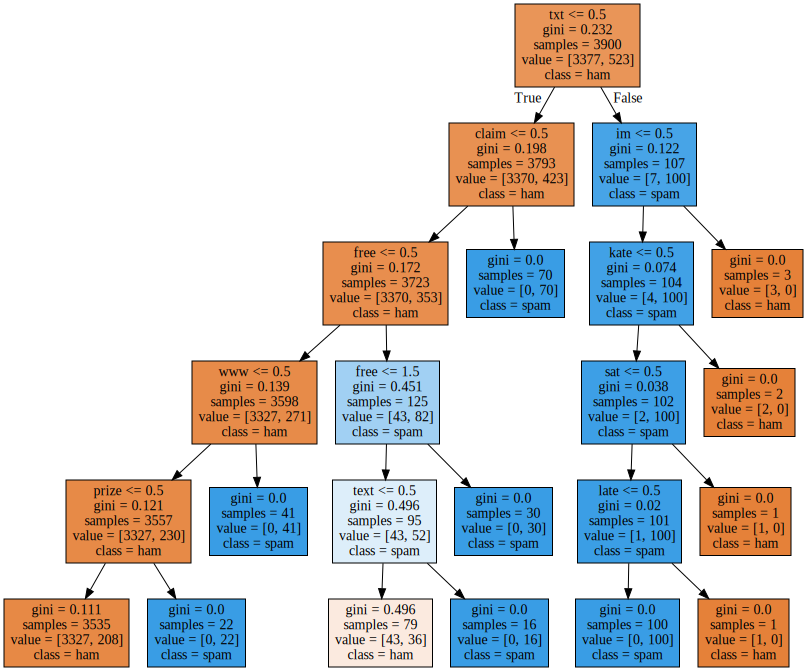

In [25]:
visualize_tree(decisionTree, vec.get_feature_names())

This confusion matrix clearly shows the unbalanced dataset (1148 ham messages against 224 spam messages). It comes as no surprise that the precision for ham is high as we have a lot of training samples which are ham. 
If we go for a system were we would introduce a sort of spam folder in our sms inbox, we can go for a solution were we keep our sms inbox clean from spam and classify a bit more aggressive towards the spam site. In other words, we would optimize to minimize the False Negatives or optimize for a high recall. At this moment, we predicted 124 messages as ham which were actually spam (recall= 0.45). We'll try to improve on that.

In the document, the Matthews correlation coefficient is used as metric to evaluate the model. Follow the link for more info on
[Why MCC is a good bin classification metric for unbalanced datasets](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)

Possible MCC values range between -1 and 1
* close to 1 means that the predictions are good (high correlation between truth and prediction)
* close to 0 means that the predictions are bad (low to no correlation between truth and prediction)
* close to -1 means the opposite of the prediction is true (high negative correlation between truth and prediction)

So a lot to improve here

#### TfIdfVectorizer + DecisionTree
Let's also try with the TfidfVectorizer. From wikipedia,
In information retrieval, tf–idf (also TF*IDF, TFIDF, TF-IDF, or Tf-idf), short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf

In [26]:
dt_tfIdf = DecisionTreeClassifier(max_depth=5)
evaluate(vectorize_predict(
    TfidfVectorizer(ngram_range=(1,1), max_features=20000,stop_words=ENGLISH_STOP_WORDS),
    decisionTree))


Classification report:
               precision    recall  f1-score   support

         ham       0.92      0.99      0.96      1448
        spam       0.91      0.48      0.63       224

    accuracy                           0.92      1672
   macro avg       0.92      0.74      0.79      1672
weighted avg       0.92      0.92      0.91      1672



MCC:  0.6252


At first sight, Tfidf does not seem to improve our recall.
Instead of manually trying different settings, let gridsearch do the work and optimize for recall

## 1.3 Feature engineering and model (hyperparameter) Training

We now use grid search to see what parameter combination works best. The gridSearchCV also does cross validation of the training set (cv=5 so a split up in 5 folds).
We do play around a bit with dimensionality reduction using TruncatedSVD() (PCA has problems with sparse data). This degrades the performance of our filter. Dimensionality reduction can reduce the resource usage drastically without losing a lot of the variance in the features (remaining variance can be specified as a float in n_components parameter of PCA).
As currently the number of words (features) is limited to 10000 and the number of samples is < 6000, it is still doable without dimensionality reduction.

In [27]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer

scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1': make_scorer(f1_score, average = 'macro')}
vect_preprocessing_pipeline = ColumnTransformer(transformers=[
           ('vec', TfidfVectorizer(),"Message"),
            #('tfidf', TfidfTransformer(),"Message") 
],remainder='passthrough')

dt_pipeline = Pipeline([
           ('x', vect_preprocessing_pipeline),
           ('red', TruncatedSVD(n_components=100)),
           ('dt', DecisionTreeClassifier(random_state=23)),
])
params = [
    {
    'x__vec__max_df': (0.75, 1.0),
    'x__vec__max_features': (5000, 10000),
#     'x__vec__stop_words': [None, ENGLISH_STOP_WORDS],
    'x__vec__ngram_range': ((1, 1), (1, 2)),  
#     'x__vec__use_idf': (True, False),
    'x__vec__norm': ('l1', 'l2', None),
    'red':['passthrough',TruncatedSVD(n_components=100)],
    'dt__criterion' : ['gini'],
    'dt__max_depth' : [5,7,11]
},
    {
    'x__vec': (CountVectorizer(),),
    'x__vec__max_df': (0.75, 1.0),
    'x__vec__max_features': (5000, 10000),
    #'x__vec__stop_words': [None, ENGLISH_STOP_WORDS],
    'x__vec__ngram_range': ((1, 1), (1, 2)),  
    'red':['passthrough',TruncatedSVD(n_components=100)],
    'dt__criterion' : ['gini'],
    'dt__max_depth' : [5,7,11]
}
]

gs = GridSearchCV(dt_pipeline, params, n_jobs=-1, verbose=1, cv=5, scoring=scoring,refit="recall")

In [28]:
# quite a few combinations here to test with the brute force GridSearchCV, 
# RandomizedSearchCV gives faster results as it samples the parameter to the number specified in n_iter
fitted_gs =gs.fit(X_train,y_train)


Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [29]:
print(gs.scoring)
print(gs.score(X_test, y_test))
print(gs.best_estimator_)

{'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score, average=macro), 'recall': make_scorer(recall_score, average=macro), 'f1': make_scorer(f1_score, average=macro)}
0.9458982833464877
Pipeline(steps=[('x',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_df=0.75,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  norm=None),
                                                  'Message')])),
                ('red', 'passthrough'),
                ('dt', DecisionTreeClassifier(max_depth=11, random_state=23))])


On the training set
-------------------
Classification report:
               precision    recall  f1-score   support

         ham       0.99      1.00      1.00      3377
        spam       0.99      0.96      0.97       523

    accuracy                           0.99      3900
   macro avg       0.99      0.98      0.98      3900
weighted avg       0.99      0.99      0.99      3900



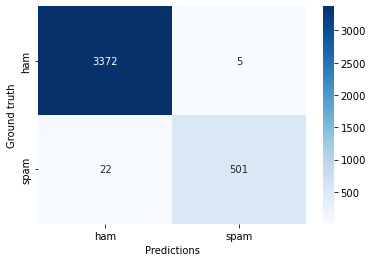

MCC:  0.9700
On the test set
-------------------
Classification report:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1448
        spam       0.96      0.90      0.93       224

    accuracy                           0.98      1672
   macro avg       0.97      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



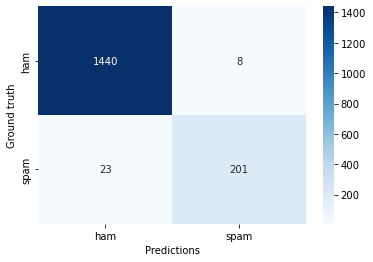

MCC:  0.9185


In [30]:
dt_pipeline.set_params(**gs.best_params_)
dt_pipeline.fit(X_train,y_train)

print('On the training set')
print('-------------------')
best_y_train_pred = dt_pipeline.predict(X_train)
evaluate_any(y_train, best_y_train_pred)

print('On the test set')
print('-------------------')
best_y_test_pred = dt_pipeline.predict(X_test)
evaluate(best_y_test_pred)

The accuracy score for the training set and test set are pretty close to each other. This is an indicator that we did not overfit the model. To be absolutely sure it would be good to plot the training and test set results and see were they are closest to each other. That would be the point were the fit is optimal and we minimize underfitting and overfitting for the current model.


In [31]:

tokens = dt_pipeline.steps[0][1].get_feature_names()
#print(tokens)
dt_pipeline['dt'].feature_importances_.sort()

print(f"Most important features (total {len(dt_pipeline['dt'].feature_importances_)})")
for importance, name in sorted(zip(dt_pipeline['dt'].feature_importances_, tokens),reverse=True)[:20]:
    print (name, f'{importance:.3f}')

Most important features (total 10004)
PhoneNumberCount 0.830
vec__uk 0.036
vec__www 0.018
vec__your mobile 0.018
vec__30 0.013
vec__tones 0.009
vec__reply stop 0.007
vec__text 0.007
vec__http 0.007
vec__bad 0.007
vec__txt 0.005
vec__arsenal 0.005
vec__by replying 0.005
vec__yun 0.004
vec__said 0.004
vec__go for 0.004
vec__with 0.003
vec__mb 0.002
vec__carry 0.002
vec__ppl 0.002


Performance of the test set measured in MCC is 0.92. 
Compared to the MCC in the SMS Spam filtering study, this model performs better than their best.
The newly introduced `PhoneNumberCount` feature is by far the most important feature.
The hyperparameters for our model:
``
TfidfVectorizer(max_df=0.75, max_features=10000, ngram_range=(1,2),norm=None)
=> no normalisation and ngram of 1 or 2 words
TruncatedSVD :'passthrough' 
=> no dimensionality reduction gives the best results
DecisionTreeClassifier(max_depth=11, random_state=23)
``

Plotting the tree gives an explainable insight into the decisions made on every level. You can clearly see the PhoneNumberCount on top with a very decent split towards the spam side (the underlying nodes having all a very good gini).

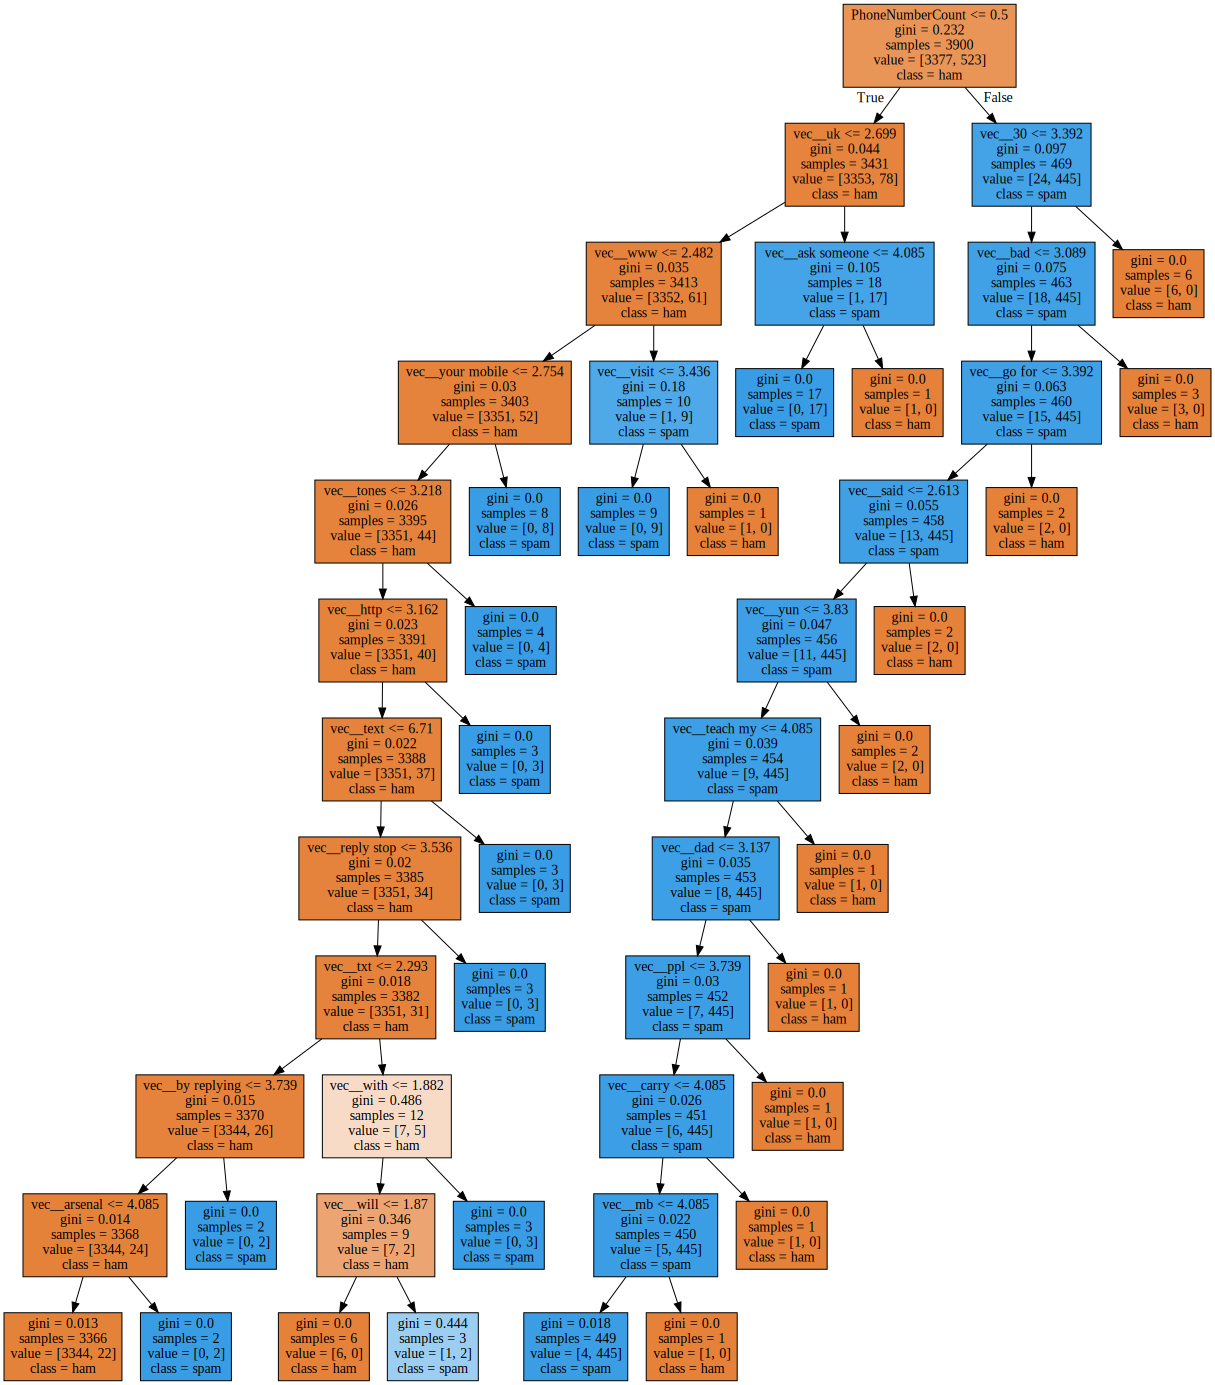

In [32]:
visualize_tree(dt_pipeline['dt'],tokens)

## 1.4 Further exploration

### Other features and models

To build a better performing model, other features could be added. For example adding the source sms number (if any) combined with a contact list of the consumer could really improve the performance of the filter.

Decision tree is of course only one of the possible classifiers. We will try a few others here:
* An linear SVM `LinearSVC`
* `RandomForestClassifier` 
* Naive Bayes `MultinomialNB`


In [33]:
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler,PowerTransformer, QuantileTransformer

exp_pipeline = Pipeline([
           ('x', vect_preprocessing_pipeline),
           ('red', TruncatedSVD(n_components=100)),
           ('pre', StandardScaler()),
           ('dt', LinearSVC(max_iter=10000, random_state=25)),
])
exp_params = [
    {
       'x__vec': (TfidfVectorizer(max_df=0.75, max_features=5000),),
       'red': (TruncatedSVD(n_components=100),),
       'dt': (LinearSVC(C=1, max_iter=10000, random_state=25),) 
#     'x__vec__max_df': (0.75, 1.0),
#     'x__vec__max_features': (5000, 10000),
# #     'x__vec__stop_words': [None, ENGLISH_STOP_WORDS],
#     'x__vec__ngram_range': ((1,1),(1, 2)),  
# #     'x__vec__use_idf': (True, False),
#     'x__vec__norm': ('l2', None),
#     #'red':['passthrough',TruncatedSVD(n_components=100)],
#     'dt__C': [0.1 , 1, 10] 
    },
    {
       'x__vec': (TfidfVectorizer(max_df=0.75, max_features=10000,ngram_range=(1,2),norm=None),),
        'red':('passthrough',),
        'pre':('passthrough',),
        'dt': (RandomForestClassifier(random_state=26,max_depth=13, max_features=0.2),),
#         'dt': (RandomForestClassifier(random_state=26),),
#         'dt__max_depth': [7,9,11,13],
#         'dt__max_features': ['sqrt', 0.2],
    },
    {
        'x__vec': (TfidfVectorizer(max_df=0.75, max_features=10000,ngram_range=(1,2),norm=None),),
        'red':('passthrough',),
        'pre':('passthrough',),
        'dt': (MultinomialNB(alpha=1.5),),
    },
    {
        'x__vec': (TfidfVectorizer(max_df=0.75, max_features=10000,ngram_range=(1,2),norm=None),),
        'red':('passthrough',),
        'pre':('passthrough',),
        'dt': (DecisionTreeClassifier(max_depth=11, random_state=23),),
    }
]

exp_gs = GridSearchCV(exp_pipeline, exp_params, n_jobs=-1, verbose=1, cv=5, scoring=scoring,refit="recall")

In [34]:
exp_gs_fit = exp_gs.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Pipeline(steps=[('x',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_df=0.75,
                                                                  max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  norm=None),
                                                  'Message')])),
                ('red', 'passthrough'), ('pre', 'passthrough'),
                ('dt', MultinomialNB(alpha=1.5))])
Classification report:
               precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3377
        spam       0.97      0.99      0.98       523

    accuracy                           0.99      3900
   macro avg       0.99      0.

MCC:  0.9781
Classification report:
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1448
        spam       0.94      0.92      0.93       224

    accuracy                           0.98      1672
   macro avg       0.96      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



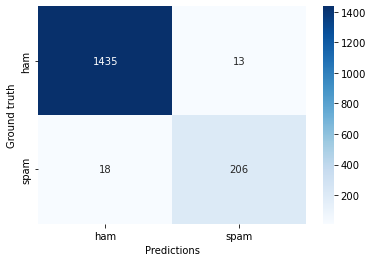

MCC:  0.9194


In [35]:
print(exp_gs.best_estimator_)
exp_best_y_train_pred = exp_gs.predict(X_train)
evaluate_any(y_train, exp_best_y_train_pred)
exp_best_y_test_pred = exp_gs.predict(X_test)
evaluate(exp_best_y_test_pred)


In [36]:
grid_temp= pd.DataFrame(exp_gs.cv_results_)[['param_dt',
                            'mean_test_accuracy',
                            'mean_test_precision',
                            'mean_test_recall',
                            'mean_test_f1',
                           ]]
grid_temp['key']= grid_temp.apply(lambda x: f"{str(x['param_dt']).partition('(')[0]}", axis=1)
grid_temp.set_index('key', inplace=True)
grid_result = grid_temp[[   'mean_test_accuracy',
                            'mean_test_precision',
                            'mean_test_recall',
                            'mean_test_f1',
                           ]].transpose()
fig = px.bar(data_frame=grid_result,
            y=grid_result.columns, barmode='group',range_y=(0.8,1), text_auto=".3f")

fig.show()

Performance of the different classifiers are very close to each other. Decision trees have the advantage of being explainable. Multinomial is slightly performing better than the other classifiers.